## Task
1. see how many such game sentences with AtLocation we can create, and how many answers they have on average (the example above has 3 answers).  Also, inspect their quality and if you detect problems, see how they can be addressed.
2. Think and investigate how other relations can be used to create related tasks. I think some should be possible, like UsedFor in this example: "I want to cut paper so I will need knife or scissors". You don't need to think about all relations but take some subset of let's say 10 that seem promising.
3. Take the 50 household items from EQA that we worked with, and generate random walks of length 2 and 3 on the graph starting with them. Example for a random walk of length 2 is: toaster-LocatedAt-kitchen-UsedFor-cooking. You could do this with graph-tools for example (https://graph-tool.skewed.de/static/doc/quickstart.html)
4. Think and investigate how can we generate game sentences with these walks, and whether it makes sense. One option would be to do something like "A toaster can be located in a place that is used for cooking and baking."  Even if we can do this for a small set of patterns, it would be useful. The solution could also use disambiguation or other NLP tricks. 
5. It would be useful to see some examples where we can use these walks to create sentences. You don't need to code this last part 5.

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import random, re
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
from numpy import dot
from numpy.linalg import norm
import pickle, os

## Set up Folder

**cskg_dim_folder**: the location of file, cskg_dim.tsv  
**cskg_embeddings_file**: the location of file, cskg_embeddings.txt  
**AtLocation_sents_file**: the location of file whose relation is AtLocation  
**gamesents_file**: the location of file whose relation is defined by ourself.  
**hops_avg**: 4-hops scenes sorted by avg cosine similarity  
**hops_min**: 4-hops scenes sorted by min cosine similarity  
**centric_avg**: node-centric scenes sorted by avg cosine similarity
**centric_min**: node-centric scenes sorted by min cosine similarity

In [2]:
# input
cskg_dim_folder="./data/cskg_dim/cskg_dim.tsv"
cskg_embeddings_file="../psl/cskg_embedding/cskg_embeddings.txt"

# output
AtLocation_sents_file="./data/psl/AtLocation_sents.txt"
gamesents_file="./data/psl/gamesents.txt"
hops_avg="../psl/GameSentence/4-hops-AvgSim.txt"
hops_min="../psl/GameSentence/4-hops-MinSim.txt"
centric_avg="../psl/GameSentence/node-centric-AvgSim.txt"
centric_min="../psl/GameSentence/node-centric-MinSim.txt"

## Data Preprocess

In [3]:
def load_source(filename):
    # load file
    # output file head and content
    with open(filename,"r",encoding="utf-8") as f:
        head=f.readline().strip().split("\t")
        data=[]
        for line in f:
            temp=line.strip().split("\t")
            data.append([item.split("|")[0] for item in temp])
            
    return head, data

def data_filter(head, lines, filter_={"relation":["/r/AtLocation"]}):
    # filter the lines with limitation
    for head_name in filter_:
        filter_values=filter_[head_name]
        line_index=head.index(head_name)
        
        for filter_value in filter_values:
            filter_lines=[]
            for line in lines:
                if line[line_index]==filter_value:
                    filter_lines.append(line)
            yield filter_value,filter_lines
        
def build_sentence(lines, sent_format='f"I am going to {blank1} and I am going to see {blank2}"',operation="or",reverse_format=False):
    # build sentence based on lines
    # input:
        #lines: the filter line
        #sent_format: Structure to generate sentence
    # output:
    # example: Example: I am going to A and I am going to see B or C or D.
        # sents: The generated game sentence
        # top_bot: a dictionary,{A:[B,C,D,...]}
    top_bot=dict()
    if not reverse_format:
        for line in lines:
            subject_id=line[1]
            subject_label=line[4]

            object_id=line[3]
            object_label=line[5]

            temp=top_bot.get(object_label,[])
            temp.append(subject_label)

            top_bot[object_label]=temp
            
    else:
        for line in lines:
            subject_id=line[1]
            subject_label=line[4]

            object_id=line[3]
            object_label=line[5]

            temp=top_bot.get(subject_label,[])
            temp.append(object_label)

            top_bot[subject_label]=temp
    
    # build sentence
    sents=[]
    for top in top_bot:
        bots=top_bot[top]
        
        blank1=top
        blank2=f" {operation} ".join(bots)
        sents.append(eval(sent_format).replace("_"," "))
        
    return sents, top_bot

In [4]:
# load cskg_dim file
cskg_dim_head,cskg_dim_lines=load_source(cskg_dim_folder)

In [5]:
# head
cskg_dim_head

['id',
 'node1',
 'relation',
 'node2',
 'node1;label',
 'node2;label',
 'relation;label',
 'relation;dimension',
 'source',
 'sentence']

In [6]:
# example of lines
cskg_dim_lines[0]

['/c/en/0-/r/DefinedAs-/c/en/empty_set-0000',
 '/c/en/0',
 '/r/DefinedAs',
 '/c/en/empty_set',
 '0',
 'empty set',
 'defined as',
 'similarity',
 'CN',
 '[[0]] is the [[empty set]].']

## Build AtLocation Sentence
Extract the lines whose relation id is /r/AtLocation.  
Then try to build game sentence basd on each lines.  
Example: I am going to drawer and I am going to see XX or XX or XX.

In [7]:
# find the sentence that relation is "/r/AtLocation"
mul_filter_lines=list(data_filter(cskg_dim_head, cskg_dim_lines, filter_={"relation":["/r/AtLocation"]}))

In [8]:
# example of lines with relation /r/AtLocation
mul_filter_lines[0][0], mul_filter_lines[0][1][0]

('/r/AtLocation',
 ['/c/en/00t_shirts-/r/AtLocation-/c/en/drawer-0000',
  '/c/en/00t_shirts',
  '/r/AtLocation',
  '/c/en/drawer',
  '00t shirts',
  'drawer',
  'at location',
  'spatial',
  'CN',
  '*Something you find in [[a drawer]] is [[00t-shirts]]'])

In [9]:
AtLocation_sents,AtLocation_dict = build_sentence(mul_filter_lines[0][1])
print("game sentences with AtLocation we can create:",len(AtLocation_dict))

# statistic of location sentence
example_distribution=[len(AtLocation_dict[item]) for item in AtLocation_dict]
avg_example= sum(example_distribution)/len(AtLocation_dict)
print("answers they have on average:", avg_example)

game sentences with AtLocation we can create: 7771
answers they have on average: 3.5770171149144256


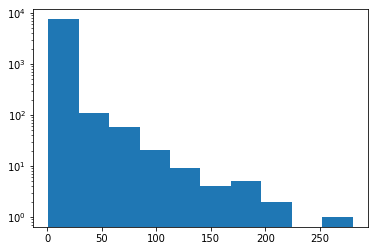

In [10]:
a=plt.hist(example_distribution,log=True)

In [11]:
# save file to desk
with open(AtLocation_sents_file,"w",encoding="utf-8") as f:
    for line in AtLocation_sents:
        f.write(line+"\n")

## Build Sentences Based on More Relations
Similar work with **Build AtLocation Sentence**  
In this task, more relation id and sentence format will be defined in this task  
According to relation distribution, 11 different relation id are chosen as the relation limitation.

In [12]:
# find the distribution of relation id
rel_dict=dict()
for line in cskg_dim_lines:
    rel_dict[line[2]]=rel_dict.get(line[2],0)+1
    
print("number of relation id:", len(rel_dict))

number of relation id: 47


In [13]:
# define the first word and second word used for build sentence for :
# example:
# [I am going to], [and I am going to see]
relation_sentence={"/r/UsedFor":[['f"I want to {blank1} so I will need {blank2}"',"or",False],
                                 ['f"I want to have {blank1} so I will need {blank2}"',"or",False],
                                 ['f"I want to be {blank1} so I will need {blank2}"',"or",False]],
                   "/r/CreatedBy":[['f"I have {blank1} so I can create {blank2}"',"or", False]],
                   "/r/CapableOf":[['f"I have {blank1} so I am capable of {blank2}"',"or", True],
                                     ['f"I am {blank1} so I am capable of {blank2}"',"or", True]],
                   "/r/Causes":[['f"I have {blank1} so I will cause {blank2}"',"or", True],
                                  ['f"I am {blank1} so I will cause {blank2}"',"or", True]],
                   "/r/PartOf":[['f"I have {blank1} so I might also have {blank2}"',"or", False],
                                  ['f"I am {blank1} so I might also have {blank2}"',"or", False]],
                   "/r/MadeOf":[['f"I want to have {blank1} so I can make it from {blank2}"',"or", True]],
                   "/r/HasPrerequisite":[['f"If I want to {blank1} then I should {blank2}"',"or", True],
                                           ['f"If I want to be {blank1} then I should {blank2}"',"or", True],
                                           ['f"If I want to have {blank1} then I should {blank2}"',"or", True]],
                   "/r/CausesDesire":[['f"I want to {blank1} then I want to {blank2}"',"or", False],
                                        ['f"I want to {blank1} then I have {blank2}"',"or", False]],
                   "/r/NotDesires":[['f"I am {blank1} and I don\'t want to {blank2}"',"or", True]],
                   "/r/AtLocation":[['f"I need {blank1} so I will go to see {blank2}"',"or", True]],
                   '/r/LocatedNear':[['f"I am going to {blank1} and I am going to see {blank2} nearby"',"or", True]]}


# get the sentence that having the relation in relation_sentence
mul_filter_lines=list(data_filter(cskg_dim_head, cskg_dim_lines, filter_={"relation":relation_sentence.keys()}))

In [14]:
sents_example=[]
# build sentence based on different relation limitation and write to desk
# for each line, three different sentence will be generated.
with open(gamesents_file,"w",encoding="utf-8") as f:
    for rel_id, lines in mul_filter_lines:
        temp= []
        for format_ in relation_sentence[rel_id]:
            sents,example_dict = build_sentence(lines,
                                 sent_format=format_[0],
                                 operation=format_[1],
                                 reverse_format=format_[2],)

            example_distribution=[len(example_dict[item]) for item in example_dict]
            avg_example= sum(example_distribution)/len(example_dict)
            if not temp:
                temp= [[sents[i]] for i in range(len(sents))]
            else:
                temp=[temp[i]+[sents[i]] for i in range(len(sents))]

        sents_example.append([rel_id,temp,example_dict])

        # save file into desk

        f.write("**"+rel_id+"**\n")
        for line in sents:
            f.write(line+"\n")

In [15]:
# example of output
# for the relation /r/Causes, each collections will generate two different format sentence
sents_example[3][0], sents_example[3][1][:3]

('/r/Causes',
 [['I have coerce so I will cause act', 'I am coerce so I will cause act'],
  ['I have acting in play so I will cause applause or attention or audience to laugh or become famous or becoming professional actor or being on stage or big ego or breaking leg or comraderie with other actors or drama or dread of reviews or embarrasment or entertaining others or fall or fame and wealth or fun or gaining exposure or getting famous or getting noticed by agent or getting paid or illogical or imitate other character or laughter or looking foolish or might get applause or muscle or pride or receiving roses or satisfactory or silliness or speaking dialogue or stage fright or sudden reknown or win leading role',
   'I am acting in play so I will cause applause or attention or audience to laugh or become famous or becoming professional actor or being on stage or big ego or breaking leg or comraderie with other actors or drama or dread of reviews or embarrasment or entertaining others or 

## Score sentence
In this task, we define the score sentence which use perplexity to exsimate sentence quality.

In [16]:
# build gpt model
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

def score(tokens_tensor):
    # input sentence tensor
    # output score
    loss=model(tokens_tensor, labels=tokens_tensor)[0]
    return np.exp(loss.cpu().detach().numpy())

def sents_pick(sents,scores,perplexity_threhold=100):
    # filter sents based on perplexity
    i = min(len(sents), len(scores))
    sents_result=[]
    for idx in range(i):
        sent_collect=sents[idx]
        score_collect=scores[idx]
        
        temp=float("inf")
        result=""
        
        result_idx=0
        temp_idx=0
        for sent, score in zip(sent_collect,score_collect):
            if temp>score:
                temp=score
                result=sent
                result_idx=temp_idx
            temp_idx+=1
        if temp < perplexity_threhold:
            sents_result.append([result_idx,result])
        
    return sents_result

In [17]:
# if file exists load file otherwise run by yourself (2 hours)
# relation_scores 
isfile_=os.path.isfile("GameSentence.pkl")
if not isfile_:
    dsad
    relation_scores=[]
    for relation_collection in sents_example:
        rel_id=relation_collection[0]
        scores=[]
        print("process relation id:", rel_id)
        for sents in tqdm(relation_collection[1]):
            temp=[]
            for sent in sents:
                # too long sentence might out of index
                if len(sent)>2000:
                    temp.append(float("inf"))
                    continue
                tokens_tensor = tokenizer.encode(sent, add_special_tokens=False, return_tensors="pt")           
                temp.append(score(tokens_tensor))
            scores.append(temp)
        relation_scores.append([rel_id,scores])
    
    # store the result to desktop
    with open("GameSentence.pkl", 'wb') as output:  # Overwrites any existing file.
        pickle.dump(relation_scores, output, pickle.HIGHEST_PROTOCOL)    
else:
    with open("GameSentence.pkl", 'rb') as input:
        relation_scores = pickle.load(input)

In [18]:
# find the sentence with highest score/lowest perplexity and satisfy threshold (100 default)
# the output filtered_sents_example is considered as the high quality sentence
filtered_sents_example=[]

for idx_1 in range(len(sents_example)):
    rel_id=sents_example[idx_1][0]
    example_dict=sents_example[idx_1][2]
    sents=sents_example[idx_1][1]
    scores=relation_scores[idx_1][1]
    
    filtered_sent=sents_pick(sents,scores)
    filtered_sents_example.append([rel_id,filtered_sent,example_dict])

In [19]:
# based on the high quality sentence, extract the infomation including (subject, relation, object) to edges.
edges=[]
for relation_sents in filtered_sents_example:
    rel_id=relation_sents[0]
    ids_sents=relation_sents[1]
    patterns_=relation_sentence[rel_id]
    for id_, sent in tqdm(ids_sents):
        pattern_undefine=patterns_[id_][0]
        reverse=patterns_[id_][2]
        connection=patterns_[id_][1]
        pattern=pattern_undefine.replace("{blank1}","(.*)").replace("{blank2}","(.*)").replace('f"',"").replace('"',"")
        
        blank1,blank2s=re.findall(pattern, sent)[0]
        blank2s_list=blank2s.split(" "+connection+" ")
        
        for blank2 in blank2s_list:
            if reverse:
                subject_=blank1
                object_=blank2
                edges.append([subject_,rel_id,object_])
            else:
                subject_=blank2
                object_=blank1
                edges.append([subject_,rel_id,object_])

100%|██████████| 1633/1633 [00:00<00:00, 41314.09it/s]


In [20]:
# example of edges:
edges[0]

['accommodation', '/r/UsedFor', 'place to stay']

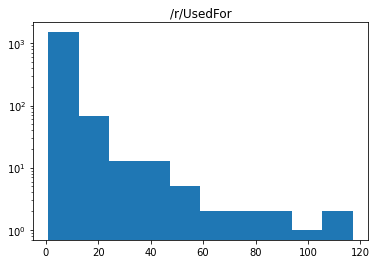

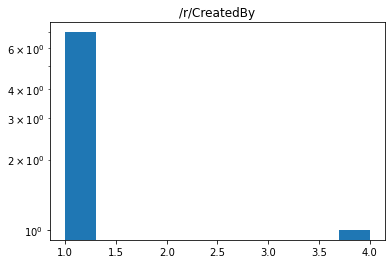

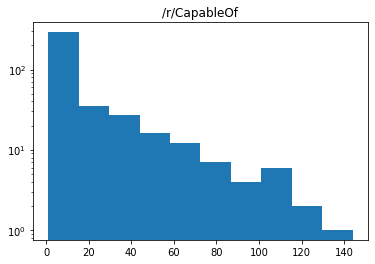

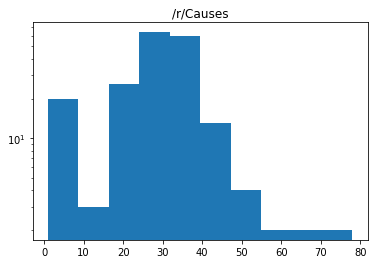

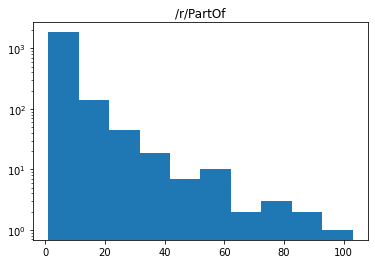

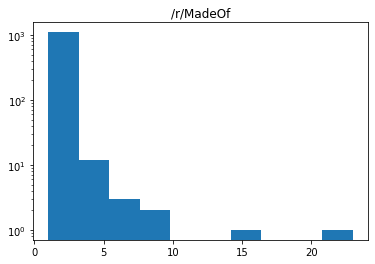

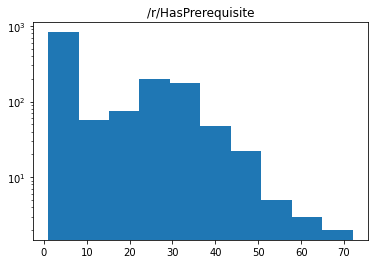

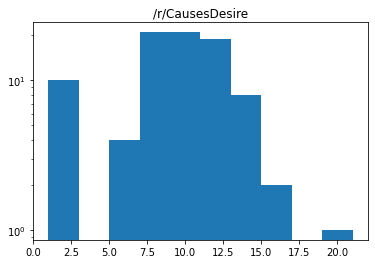

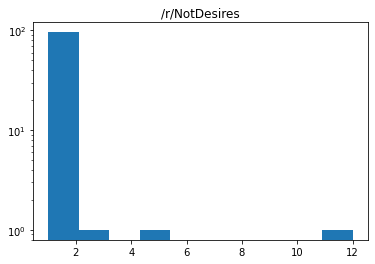

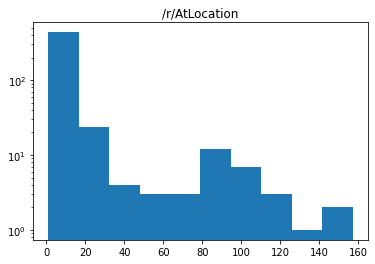

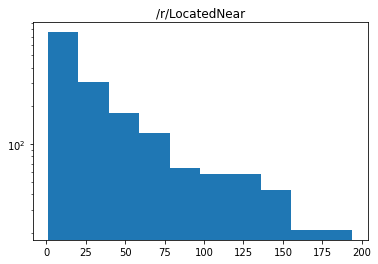

In [21]:
# calculate the number of answer for different relation id

for relation_sents in filtered_sents_example:
    fig = plt.figure()
    # count the number of " or " n1 in the sentence
    # the answer of one sentence is n1+1
    rel_id=relation_sents[0]
    id_sents=relation_sents[1]
    distribution=[]
    for id_, sent in id_sents:
        num_or = sent.count(" or ")
        distribution.append(num_or+1)    
    a=plt.hist(distribution,log=True)
    plt.title(rel_id)

# Build Graph and Build Game Sentence by Random Walk
Based on the edges obtained in the previous task, use these edges to build graph and make a random walk.  
Use the generated random walk to build game sentences.  
The quality of game sentences is evaluated by GPT-2

In [22]:
def random_walk(num=2):
    # make a random walk with the threshod num in graph
    # input: 
        #num:depth of walk
    #output:
        #process:a random walk result
    step=0
    process=[]
    root=None
    
    while step<num:
        # random select root
        if root == None:
            root_name = random.sample(label_limit, 1)[0]
            if root_name in G:
                root=G[root_name]
            else:
                continue
            
        else:
            #print(list(root.out_neighbors()))
            root_name= random.sample(root.keys(), 1)[0]
            if root_name in G:
                root=G[root_name]
            else:
                step=0
                process=[]
                root=None
                continue
            #print("second root", root)
        
        if G.out_degree[root_name]==0:
            step=0
            process=[]
            root=None
            continue
        
        #print(root,root.out_degree())
        if root_name in process:
            step=0
            process=[]
            root=None
            continue
        process.append(root_name)
        step+=1
    process.append(random.sample(root.keys(), 1)[0]) 
    return process

def all_relation_walk(threshold=100,relation_list=["/r/UsedFor"]):
    # generate a sentence with relation labels limitation
    # input: 
        #relation_list: list of relation id that use to filter random walk
        #threshold: the max iteration
    # output:
        #a random walk that contains all relation id in relation list. example:[obj1, obj2, obj3,...]
    relation_set=set(relation_list)
    process=[]
    root_name=""
    step=0
    
    while step<threshold:
        step+=1
        if root_name == "":
            root_name = random.sample(label_limit, 1)[0].replace(" ","_")
            if root_name in G:
                pass
            else:
                root_name = ""
                continue
                
        else:
            #print(list(root.out_neighbors()))
            all_edges=list(G.out_edges(root_name, data=True))
            random.shuffle(all_edges)
            status = False
            for sub, obj, rel in all_edges:
                rel_label=rel["label"]
                if rel_label in relation_set:
                    status=True
                    break
            
            if status:
                root_name=obj
                relation_set.remove(rel_label)
                if relation_set==set():
                    process.append(root_name)
                    break
            else:
                process=[]
                root_name=""
                relation_set=set(relation_list)
                continue
            #print("second root", root)
        
        if G.out_degree[root_name]==0:
            process=[]
            root_name=""
            relation_set=set(relation_list)
            continue
        
        #print(root,root.out_degree())
        # remove duplicate
        if root_name in process:
            process=[]
            root_name=""
            continue

        process.append(root_name)
    return process

def walk_sent(process):
    # add relation id between two objects in random walk
    # output example: [obj1, rel1, obj2, rel2, obj3, rel3, obj4....]
    sent=""
    for p2 in range(1, len(process)):
        p1=p2-1
        sub=process[p1].replace(" ","_")
        obj=process[p2].replace(" ","_")
        
        relation_=G[sub][obj]["label"]
        
        if sent:
            sent+="-"+relation_+"-"+obj
        else:
            sent=sub+"-"+relation_+"-"+obj
            
    return sent

def walk2gamesents(sent, relation2label, relation_swap={"/r/LocatedNear"}):
    # transfer random walk to sentence
    # input: 
        #sent: a random walk [obbj1, rel1, obj2, rel2, ....]
        #relkation2label: relation label for different relation id
        #relation swap: the relation that you want to use the relation label in cskg_dim instead of self defined
    # output:
        #gamesent: Game Sentence
    sent_token=sent.split("-")
    gamesent=""
    i=0
    while i < len(sent_token):
        if i==0:
            gamesent+=sent_token[i].replace("_"," ")
        
        elif i==1:
            rel_id=sent_token[i]
            if rel_id in relation_swap:
                rel_label=G_total[sent_token[i-1]][sent_token[i+1]]["label"]
            else:
                rel_label=relation2label[sent_token[i]]
            
            gamesent+=" "+rel_label
            
        elif (i+1)%2==0:
            gamesent+=" "+ "that"+" "+relation2label[sent_token[i]]
        
        else:
            gamesent+= " "+sent_token[i].replace("_"," ")
        i+=1
    return gamesent

In [23]:
# define the relation label 
relation2label={"/r/UsedFor":"is used for","/r/CreatedBy":"is created by","/r/CapableOf":"is capable of",
                "/r/Causes":"casuses","/r/PartOf":"is part of","/r/HasContext":'has context,',"/r/MadeOf":"is made of",
                "/r/HasPrerequisite":"has prerequisite,","/r/CausesDesire": "causes desire,","/r/NotDesires":"does not desire",
                "/r/AtLocation":"is located in","/r/LocatedNear":"is located near in"}

In [24]:
# define the subject of sentence
label_limit = set(["rug","piano","dryer","computer","fireplace","whiteboard","bookshelf","wardrobe cabinet",
                  "pan","toilet","plates","ottoman","fish tank","dishwasher","microwave","water dispenser",
                  "bed","table","mirror","tv stand","stereo set","chessboard","playstation","vacuum cleaner",
                  "cup","xbox","heater","bathtub","shoe rack","range oven","refrigerator","coffee machine",
                  "sink","sofa","kettle","dresser","knife rack","towel rack","loudspeaker","utensil holder",
                  "desk","vase","shower","washer","fruit bowl","television","dressing table","cutting board",
                  "ironing board","food processor"])

In [25]:
# based on high quality sentence extracted before to build graph.
G = nx.DiGraph()
for edge in edges:
    sub,rel,obj=edge
    sub=sub.replace(" ","_")
    obj=obj.replace(" ","_")
    G.add_edge(sub,obj,label=rel)

In [26]:
# build the graph for the whole dataset (cskg_dim).
G_total= nx.DiGraph()
for line in cskg_dim_lines:
    G_total.add_edge(line[4].replace(" ","_"),line[5].replace(" ","_"),label=line[6], head_tail=[line[1],line[3]])

In [27]:
# make a iteration to find a game sentence
# it should be noticed that for one iteration, it is possible that we cannot find a satisfied random walk

# the depth of random walk in this example is 3
for i in range(5):
    temp=random_walk(num=3)
    sent=walk_sent(temp)
    gamesent=walk2gamesents(sent, relation2label)
    tokens_tensor = tokenizer.encode(gamesent, add_special_tokens=False, return_tensors="pt")           
    value=score(tokens_tensor)
    print("random walk: ", sent)
    print("gamesentence is: ", gamesent)
    print(value)
    print()

random walk:  dresser-/r/LocatedNear-street-/r/LocatedNear-pizza-/r/LocatedNear-meat
gamesentence is:  dresser on street that is located near in pizza that is located near in meat
227.63489

random walk:  bathtub-/r/LocatedNear-molding-/r/LocatedNear-door-/r/AtLocation-union_suit
gamesentence is:  bathtub has molding that is located near in door that is located in union suit
675.00885

random walk:  television-/r/LocatedNear-staircase-/r/LocatedNear-back-/r/PartOf-body
gamesentence is:  television in front of staircase that is located near in back that is part of body
266.74973

random walk:  vase-/r/LocatedNear-head-/r/PartOf-human_body-/r/MadeOf-water
gamesentence is:  vase has a head that is part of human body that is made of water
58.375175

random walk:  computer-/r/LocatedNear-surface-/r/LocatedNear-toilet-/r/LocatedNear-caddy
gamesentence is:  computer has surface that is located near in toilet that is located near in caddy
197.67494



In [28]:
# make a iteration to find a game sentence
# it should be noticed that for one iteration, it is possible that we cannot find a satisfied random walk

# the depth of random walk in this example is 3
for i in range(5):
    temp=random_walk(num=2)
    sent=walk_sent(temp)
    gamesent=walk2gamesents(sent, relation2label)
    tokens_tensor = tokenizer.encode(gamesent, add_special_tokens=False, return_tensors="pt")           
    value=score(tokens_tensor)
    print("random walk: ", sent)
    print("gamesentence is: ", gamesent)
    print(value)
    print()

random walk:  desk-/r/LocatedNear-computer_keyboard-/r/LocatedNear-black_monitor
gamesentence is:  desk has computer keyboard that is located near in black monitor
775.3785

random walk:  vase-/r/LocatedNear-plate-/r/UsedFor-decoration
gamesentence is:  vase above plate that is used for decoration
683.93506

random walk:  piano-/r/LocatedNear-lid-/r/LocatedNear-spokes
gamesentence is:  piano has lid that is located near in spokes
2487.3958

random walk:  pan-/r/LocatedNear-pen-/r/LocatedNear-calculator
gamesentence is:  pan in pen that is located near in calculator
1075.763

random walk:  television-/r/LocatedNear-lettering-/r/LocatedNear-ball
gamesentence is:  television has lettering that is located near in ball
1141.601



In [29]:
temp=all_relation_walk(threshold=100000,relation_list=["/r/AtLocation","/r/LocatedNear","/r/UsedFor","/r/PartOf","/r/MadeOf"])
temp

['piano', 'drawing_room', 'sitting', 'porch', 'house', 'metal']

In [30]:
sent=walk_sent(temp)
gamesent=walk2gamesents(sent, relation2label)
tokens_tensor = tokenizer.encode(gamesent, add_special_tokens=False, return_tensors="pt")           
score(tokens_tensor)

73.92111

## Game Sentence by Relation Limitation
In the previous work, we find that most of relation id in random walk is just "/r/LocatedNear".  
Therefore, in this task, a random walk should also go through all realtion id that we required.  
Furthermore, the quality of game sentence is evaluated by cosine similarity and perplexity

In [31]:
# load cskg embedding file
with open(cskg_embeddings_file,"r") as f:
    head= f.readline().strip().split("\t")
    
    # obtain embedding_sentence in file
    cskg_word_embeddings=dict()
    
    for item in tqdm(f):
        # obtain list of line
        line=item.strip().split("\t")
        
        # only property is text embedding can obtain embeddings
        word=line[0]
        prop=line[1]
        embedding=line[2]
        
        if prop=="text_embedding":
            cskg_word_embeddings[word]=embedding

4322096it [00:53, 80512.35it/s]


In [32]:
example_sents_set=set()
sent_score_list=[]
relation_list=["/r/AtLocation","/r/LocatedNear","/r/UsedFor","/r/PartOf","/r/MadeOf"]
# build the game sentence and evaluate the quality of sentence by cosine similarity and perplexity
for i in tqdm(range(100)):
    temp=all_relation_walk(threshold=100000,relation_list=relation_list)
    
    if len(temp)<=len(relation_list):
        # the genrated random walk don't include all relation list
        continue
        
    node_ids=[0]*len(temp)
    for i in range(1,len(temp)):
        p1=i-1
        p2=i
        
        head=temp[p1]
        tail= temp[p2]
        
        head_tail=G_total[head][tail]["head_tail"]
        head_id= head_tail[0]
        tail_id=head_tail[1]
        
        node_ids[p1]=head_id
        node_ids[p2]=tail_id
    sent=walk_sent(temp)
    gamesent=walk2gamesents(sent, relation2label)
    
    head_id=node_ids[0]
    tail_id=node_ids[-1]
    
    head_embed=np.array(eval("["+cskg_word_embeddings[head_id]+"]"))
    similar_list=[]
    
    # calculate cosine similarity
    for idx in range(1,len(node_ids)):
        tail_id = node_ids[idx]
        tail_embed=np.array(eval("["+cskg_word_embeddings[tail_id]+"]"))
        similar=dot(head_embed, tail_embed)/(norm(head_embed)*norm(tail_embed))
        similar_list.append(similar)
        
    if gamesent in example_sents_set:
        continue
    else:
        example_sents_set.add(gamesent)
    
    # calculate perplexity
    tokens_tensor = tokenizer.encode(gamesent, add_special_tokens=False, return_tensors="pt")           
    sent_score_list.append([gamesent,score(tokens_tensor),similar_list,min(similar_list),sum(similar_list)/len(similar_list)])

100%|██████████| 100/100 [00:28<00:00,  3.46it/s]


In [33]:
# example of output
# Assume random walk is [A,rel1,B,rel2,C,rel3,D,rel4,E,rel5,F]
# gamesentence, perplexity, cosine similarity list for [AB,AC,AD,AE,AF],min cosine similarity. average cosine similarity
sent_score_list[0]

['table is made of wood that is located near in arm that is part of chair that is located in living room that is used for listening to music',
 53.159096,
 [0.49426693981095504,
  0.7344771973112891,
  0.3618574217471083,
  0.7433948467660306,
  0.47780827917298335],
 0.3618574217471083,
 0.5623609369616733]

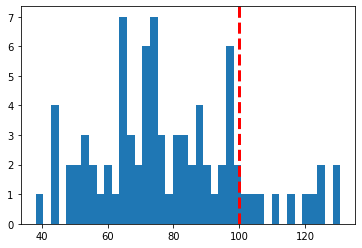

In [34]:
# distribution of perplexity
a=plt.hist([item[1] for item in sent_score_list],bins=40)
plt.axvline(100, color='r', linestyle='dashed', linewidth=3)

In [35]:
# sort sentence by average similarity
sent_score_list.sort(key=lambda k:k[-1], reverse=True)

In [36]:
# write to desk
with open(hops_avg,"w") as f:
    for line in sent_score_list:
        sent = line[0]
        similar_list=",".join([str(round(_,2)) for _ in line[2]])
        min_similar=str(round(line[3],2))
        avg_similar=str(round(line[4],2))
        
        f.write(f"Sentence: {sent}\n")
        f.write(f"Similarity List: {similar_list}\n")
        f.write(f"Min Similarity: {min_similar}\n")
        f.write(f"Avg Similarity: {avg_similar}\n")
        f.write("\n")

In [37]:
# show the top average cosine similarity game sentence
for item in sent_score_list[:10]:
    sent=item[0]
    print(sent)

ottoman is used for decoration that is located near in floor that is located in library that is part of house that is made of rooms
vase has a head that is part of human body that is made of water that is located in bottle that is used for hold
ottoman is used for sitting that is located near in chair that is located in porch that is part of house that is made of rooms
table is made of metal that is located near in towel that is located in roof that is part of house that is used for home
table is made of plastic that is located near in shelf that is located in wall that is part of building that is used for live in
table is made of wood that is located near in arm that is part of chair that is located in university that is used for learning
fireplace is used for decoration that is located near in head that is part of human body that is made of water that is located in soup
ottoman is used for sitting that is located near in chair that is located in porch that is part of house that is ma

In [38]:
# show the lowest average cosine similarity game sentence
for item in sent_score_list[-10:]:
    sent=item[0]
    print(sent)

desk as left leg that is part of person that is made of water that is located in lake that is used for sailing
table is made of stone that is located near in balcony that is located in michigan that is part of united states that is used for living in
table is made of stone that is located near in luggage that is located in trunk that is part of automobile that is used for travelling
desk as left leg that is part of person that is made of water that is located in milk that is used for drinking
piano is used for decoration that is located near in head that is part of human body that is made of water that is located in soft drink
kettle is used for water that is located in fountain that is located near in wall that is part of house that is made of building material
table is made of stone that is located in river that is located near in log that is part of ship that is used for sailing
bed is located in basement that is part of house that is located near in button that is made of plastic t

In [39]:
# sort sentence by minimum similarity
sent_score_list.sort(key=lambda k:k[-2], reverse=True)

In [40]:
# store to desk
with open(hops_min,"w") as f:
    for line in sent_score_list:
        sent = line[0]
        similar_list=",".join([str(round(_,2)) for _ in line[2]])
        min_similar=str(round(line[3],2))
        avg_similar=str(round(line[4],2))
        
        f.write(f"Sentence: {sent}\n")
        f.write(f"Similarity List: {similar_list}\n")
        f.write(f"Min Similarity: {min_similar}\n")
        f.write(f"Avg Similarity: {avg_similar}\n")
        f.write("\n")

In [41]:
# show the top min cosine similarity game sentence
for item in sent_score_list[:10]:
    sent=item[0]
    print(sent)

ottoman is used for decoration that is located near in floor that is located in library that is part of house that is made of rooms
ottoman is used for sitting that is located near in chair that is located in porch that is part of house that is made of rooms
ottoman is used for sitting that is located near in chair that is located in porch that is part of house that is made of metal
fireplace is used for decoration that is located near in head that is part of human body that is made of water that is located in soup
vase has a head that is part of human body that is made of water that is located in bottle that is used for hold
table is made of plastic that is located near in handle that is part of door that is located in school that is used for education
pan on head that is part of human body that is made of water that is located in fountain that is used for drinking
pan on head that is part of human body that is made of water that is located in can that is used for storage
heater above

In [42]:
# show the lowest min cosine similarity game sentence
for item in sent_score_list[-10:]:
    sent=item[0]
    print(sent)

piano is located in orchestra that is part of house that is located near in pen that is made of plastic that is used for plexiglass
table is made of stone that is located near in luggage that is located in trunk that is part of automobile that is used for travelling
computer near arm that is part of person that is made of water that is located in faucet that is used for draw water
table is made of stone that is located in river that is located near in log that is part of ship that is used for sailing
kettle is used for water that is located in fountain that is located near in wall that is part of house that is made of building material
piano is located in orchestra that is part of house that is located near in button that is made of plastic that is used for eyeglass lenses
sofa is located in living room that is part of house that is located near in button that is made of plastic that is used for eyeglass lenses
desk as left leg that is part of person that is made of water that is locat

# Game Sentence by Star Walk
The edges can have the thing as a subject or object
This requires double templates
X is used for Y
Y uses X

In [43]:
relation2label={"/r/UsedFor":"is used for","/r/CreatedBy":"is created by","/r/CapableOf":"is capable of",
                "/r/Causes":"casuses","/r/PartOf":"is part of","/r/HasContext":'has context,',"/r/MadeOf":"is made of",
                "/r/HasPrerequisite":"has prerequisite,","/r/CausesDesire": "causes desire,","/r/NotDesires":"does not desire",
                "/r/AtLocation":"is located in","/r/LocatedNear":"is located near",
                "/r/AtLocation/r":"has","/r/UsedFor/r":"uses","/r/PartOf/r": "has a part,","/r/MadeOf/r":"is used to make","/r/LocatedNear/r":"is located near",}
relation_list=["/r/AtLocation","/r/LocatedNear","/r/UsedFor","/r/PartOf","/r/MadeOf"]

In [44]:
G = nx.DiGraph()
for edge in edges:
    sub,rel,obj=edge
    sub=sub.replace(" ","_")
    obj=obj.replace(" ","_")
    if rel in relation_list:
        G.add_edge(sub,obj,label=rel)

In [45]:
def star_walk(threshold=100):
    # make a star walk with relation id limitation and return nodes
    nodes=["",[],[]]
    relation_limit_set=set(relation_list)
    
    for i in range(threshold):
        # pick one word from eqa
        root_name = random.sample(label_limit, 1)[0]
        
        # check whether it has 5 different relation
        if not G.has_node(root_name):
            continue
            
        out_edges=G.out_edges(root_name)
        in_edges=G.in_edges(root_name)
        relation_set=set()
        
        for u,v in out_edges:
            rel_name=G[u][v]["label"]
            relation_set.add(rel_name)
            
        for u,v in in_edges:
            rel_name=G[u][v]["label"]
            relation_set.add(rel_name)
            
        if not len(relation_set)>=len(relation_list)-2:
            #print(relation_set,root_name)
            continue
            
        #print(relation_set,root_name)
        nodes[0]=root_name
        
        shuffle_out_edges=list(out_edges)
        shuffle_in_edges=list(in_edges)
        random.shuffle(shuffle_out_edges)
        random.shuffle(shuffle_in_edges)
        #print(shuffle_out_edges,shuffle_in_edges)
        for u,v in shuffle_out_edges:
            rel_name=G[u][v]["label"]
                
            if rel_name in relation_limit_set:
                relation_limit_set.remove(rel_name)
            else:
                continue
                
            nodes[1].append(v)
            nodes[2].append(rel_name)
            
            if not relation_limit_set:
                break
                
        for u,v in shuffle_in_edges:
            rel_name=G[u][v]["label"]
            
            if not relation_limit_set:
                break
                
            if rel_name in relation_limit_set:
                relation_limit_set.remove(rel_name)
            else:
                continue
                
            nodes[1].append(u)
            nodes[2].append(rel_name+"/r") 
        
        if nodes[0]:
            break
            
    return nodes

def build_sentences(nodes):
    # generate sentence by two different formate
    root_=nodes[0]
    sent1_list=[]
    sent2_list=[]
    for node, rel_ in zip(nodes[1],nodes[2]):
        sub_sent1=f"{root_} {relation2label[rel_]} {node}"
        sub_sent2=f"{relation2label[rel_]} {node}"
        sent1_list.append(sub_sent1)
        sent2_list.append(sub_sent2)
        
    sent1=" and ".join(sent1_list)+"."
    sent2=root_+" "+" and ".join(sent2_list)+"."
    sent1=sent1.replace("_"," ")
    sent2=sent2.replace("_"," ")
    
    return sent1,sent2

In [46]:
nodes_combine=star_walk()
nodes_combine,build_sentences(nodes_combine)

(['sofa',
  ['living_room', 'watching_television', 'stitching'],
  ['/r/AtLocation', '/r/UsedFor', '/r/LocatedNear/r']],
 ('sofa is located in living room and sofa is used for watching television and sofa is located near stitching.',
  'sofa is located in living room and is used for watching television and is located near stitching.'))

In [47]:
# find random start and evaluate by perplexity
example_sents_set=set()
sent_score_list1=[]
sent_score_list2=[]
for i in tqdm(range(100)):
    nodes_combine=star_walk()
    if not nodes_combine[0]:
        continue
    sent1,sent2=build_sentences(nodes_combine)
    if sent1 in example_sents_set:
        continue
    else:
        example_sents_set.add(sent1)
    tokens_tensor = tokenizer.encode(sent1, add_special_tokens=False, return_tensors="pt")           
    sent_score_list1.append([sent1,score(tokens_tensor)])
    
    tokens_tensor = tokenizer.encode(sent2, add_special_tokens=False, return_tensors="pt")           
    sent_score_list2.append([sent2,score(tokens_tensor)])

100%|██████████| 100/100 [00:09<00:00, 10.74it/s]


In [48]:
score_list1=[]
score_list2=[]
for item1,item2 in zip(sent_score_list1,sent_score_list2):
    sent1,res1=item1
    sent2,res2=item2
    score_list1.append(res1)
    score_list2.append(res2)
    
print("Average Perplexity with format1",sum(score_list1)/len(score_list1))
print("Average Perplexity with format2",sum(score_list2)/len(score_list2))

Average Perplexity with format1 152.90131486064257
Average Perplexity with format2 170.3463178307119


The result shows that format1 is better than format2

In [49]:
example_sents_set=set()
sent_score_list1=[]
# build the game sentence and evaluate the quality of sentence by cosine similarity and perplexity
for i in tqdm(range(100)):
    nodes_combine=star_walk()
    if not nodes_combine[0]:
        continue
        
    # obatain two different sentence. However, only use the sentence 1
    sent1,sent2=build_sentences(nodes_combine)
    if sent1 in example_sents_set:
        continue
    else:
        example_sents_set.add(sent1)
        
    if "piano" in nodes_combine:
        continue
        
    node_ids=[0]*(len(nodes_combine[1])+1)
    for i in range(1,len(node_ids)):
        p1=0
        p2=i-1
        
        head=nodes_combine[p1]
        tail=nodes_combine[1][p2]
        
        try:
            head_tail=G_total[head][tail]["head_tail"]
            head_id= head_tail[0]
            tail_id=head_tail[1]
        except:
            head_tail=G_total[tail][head]["head_tail"]
            head_id= head_tail[1]
            tail_id=head_tail[0]
        head_id= head_tail[0]
        tail_id=head_tail[1]
        
        node_ids[p1]=head_id
        node_ids[p2+1]=tail_id
    
    head_id=node_ids[0]
    head_embed=np.array(eval("["+cskg_word_embeddings[head_id]+"]"))
    similar_list=[]
    
    for idx in range(1,len(node_ids)):
        tail_id = node_ids[idx]
        tail_embed=np.array(eval("["+cskg_word_embeddings[tail_id]+"]"))
        similar=dot(head_embed, tail_embed)/(norm(head_embed)*norm(tail_embed))
        similar_list.append(similar)
    
    tokens_tensor = tokenizer.encode(sent1, add_special_tokens=False, return_tensors="pt")           
    sent_score_list1.append([sent1,score(tokens_tensor),similar_list,min(similar_list),sum(similar_list)/len(similar_list)])

100%|██████████| 100/100 [00:05<00:00, 17.64it/s]


In [50]:
# example of output
# Assume random walk is [A,rel1,B,rel2,C,rel3,D,rel4,E,rel5,F]
# gamesentence, perplexity, cosine similarity list for [AB,AC,AD,AE,AF],min cosine similarity. average cosine similarity
sent_score_list1[0]

['desk is located near lines and desk is used for reading and desk has bag.',
 312.91205,
 [0.7271340259943967, 0.4712606266889892, 0.5965097600831452],
 0.4712606266889892,
 0.598301470922177]

In [51]:
# sort sentence by avg similarity
sent_score_list1.sort(key=lambda k:k[-2], reverse=True)

In [52]:
# save avg similarity to desk
with open(centric_min,"w") as f:
    for line in sent_score_list1:
        sent = line[0]
        similar_list=",".join([str(round(_,2)) for _ in line[2]])
        min_similar=str(round(line[3],2))
        avg_similar=str(round(line[4],2))
        
        f.write(f"Sentence: {sent}\n")
        f.write(f"Similarity List: {similar_list}\n")
        f.write(f"Min Similarity: {min_similar}\n")
        f.write(f"Avg Similarity: {avg_similar}\n")
        f.write("\n")

In [53]:
# top sentence
for item in sent_score_list1[:10]:
    sent=item[0]
    print(sent)

computer is used for work and computer is located near device and computer is located in classroom and computer is made of silicon and computer has a part, computer memory.
rug is located near window and rug is used for cover floor and rug has furniture.
computer is located near sticker and computer is located in library and computer is used for entertainment and computer is made of hardware and computer has a part, cpu.
bathtub is located near rug and bathtub is used for bathe and bathtub has water.
dishwasher is located near door and dishwasher is used for washing dishes and dishwasher has kitchen utensil.
dishwasher is located near window and dishwasher is used for washing dishes and dishwasher has kitchen utensil.
dresser is located near brown wood and dresser is used for storing clothes and dresser has drawer.
dresser is located near bed and dresser is used for storing clothes and dresser has drawer.
dishwasher is used for washing dishes and dishwasher is located near drawer and d

In [54]:
# lowest sentence
for item in sent_score_list1[-10:]:
    sent=item[0]
    print(sent)

microwave is located near vent and microwave is used for preparing food and microwave is part of electromagnetic spectrum and microwave has wiener dog.
microwave is located near grass and microwave is used for preparing food and microwave is part of electromagnetic spectrum and microwave has wiener dog.
microwave is located near screen and microwave is part of electromagnetic spectrum and microwave is used for preparing food and microwave has wiener dog.
microwave is located near steel and microwave is used for preparing food and microwave is part of electromagnetic spectrum and microwave has wiener dog.
microwave is located near plastic and microwave is part of electromagnetic spectrum and microwave is used for preparing food and microwave has wiener dog.
table is used for holding things and table is made of metal and table is located near toiletries and table has cup of coffee.
table is used for sitting on and table is made of plastic and table is located near icing and table has flo

In [55]:
# sort sentence by minimum similarity
sent_score_list1.sort(key=lambda k:k[-1], reverse=True)

In [56]:
with open(centric_avg,"w") as f:
    for line in sent_score_list1:
        sent = line[0]
        similar_list=",".join([str(round(_,2)) for _ in line[2]])
        min_similar=str(round(line[3],2))
        avg_similar=str(round(line[4],2))
        
        f.write(f"Sentence: {sent}\n")
        f.write(f"Similarity List: {similar_list}\n")
        f.write(f"Min Similarity: {min_similar}\n")
        f.write(f"Avg Similarity: {avg_similar}\n")
        f.write("\n")

In [57]:
#top sentence
for item in sent_score_list1[:10]:
    sent=item[0]
    print(sent)

computer is used for work and computer is located near device and computer is located in classroom and computer is made of silicon and computer has a part, computer memory.
rug is located near window and rug is used for cover floor and rug has furniture.
bathtub is located near rug and bathtub is used for bathe and bathtub has water.
rug is located near ceiling and rug is used for decoration and rug has furniture.
sink is located near can and sink is located in laundry room and sink is used for washing.
computer is located near sticker and computer is located in library and computer is used for entertainment and computer is made of hardware and computer has a part, cpu.
dresser is located near brown wood and dresser is used for storing clothes and dresser has drawer.
dishwasher is located near window and dishwasher is used for washing dishes and dishwasher has kitchen utensil.
computer is located in classroom and computer is located near living room and computer is used for play and co

In [58]:
#lowest sentence
for item in sent_score_list1[-10:]:
    sent=item[0]
    print(sent)

sofa is used for sleeping and sofa is located in house and sofa is located near leaf.
ottoman is made of blend and ottoman is used for sit on and ottoman is located near controller.
microwave is located near steel and microwave is used for preparing food and microwave is part of electromagnetic spectrum and microwave has wiener dog.
table is used for holding things and table is made of stone and table is located near fountain and table has carpet.
table is used for sitting on and table is made of plastic and table is located near icing and table has flowers.
cup is used for drinking and cup is located near r and cup has tea.
cup is used for hold and cup is located near dot and cup has tea.
cup is used for hold and cup is located near slice and cup has tea.
cup is used for drinking and cup is located near gravy and cup has tea.
rug is used for sit on and rug is located near plant and rug has dog.
